(150, 4)
dataset shape:  (150, 4)
在测试集上准确率： 0.9736842105263158
在交叉验证当中最好的结果： 0.9727095516569201
选择最好的模型是： KNeighborsClassifier(n_neighbors=3)
Time to calculate  knn.predict in UnPatched scikit-learn  0.00099 seconds
Classification report for kNN:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      0.88      0.93         8
           2       0.95      1.00      0.97        18

    accuracy                           0.97        38
   macro avg       0.98      0.96      0.97        38
weighted avg       0.98      0.97      0.97        38


Time to calculate  knn.predict in Patched scikit-learn  0.00099 seconds
Classification report for kNN:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      0.88      0.93         8
           2       0.95      1.00      0.97        18

    accuracy                           0.97       

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


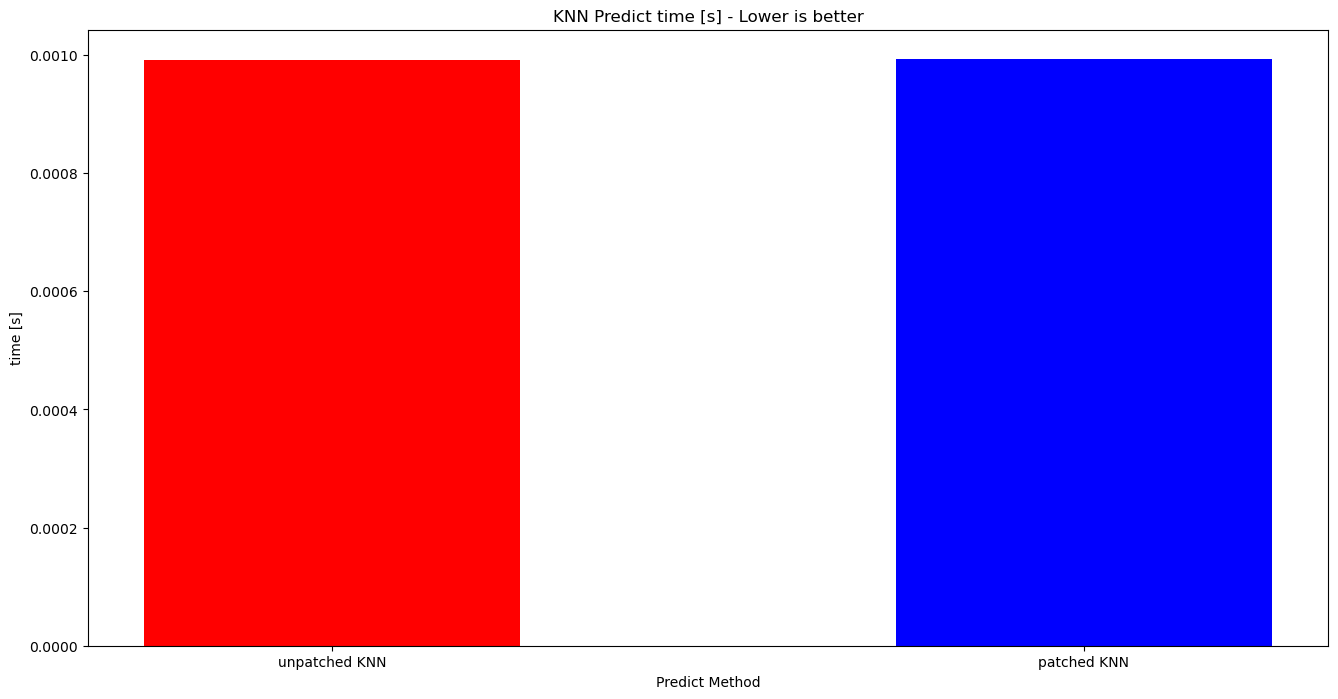

Intel(R) Extensions for scikit-learn* KNN acceleration  1.0 x!


In [142]:
from sklearn import datasets#导入sklearn数据集
from sklearn.neighbors import KNeighborsClassifier#分类
from sklearn import metrics
import time

iris = datasets.load_iris()#加载鸢尾花数据集
#print(iris.DESCR)#输出数据集的信息，查看属性，数据集数量和种类
X=iris.data#分离数据集的属性和标签，标签就是表明种类
Y=iris.target

#分离数据集为训练集和测试集，用测试集判断准确率
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=1/3,random_state=24)

#导包标准化，原理以上说过了，这里直接导包方便
from sklearn.preprocessing import StandardScaler
standardscaler=StandardScaler()
standardscaler.fit(X_train)
X_train=standardscaler.transform(X_train)
X_test=standardscaler.transform(X_test)


print('dataset shape: ', X.shape)

# #导包网格搜索，搜索算法最合适的参数
# from sklearn.model_selection import GridSearchCV#grid网格,search搜索
# # 构造一些属性
params = {'n_neighbors':[i for i in range(1,15)],
          'weights':['uniform','distance'],
          'p':[1,2]}
# # 进行网格搜索
knn=KNeighborsClassifier()
grid = GridSearchCV(knn, params,scoring='accuracy',cv=6)
grid.fit(X_train, Y_train)
# 预测准确率
print("在测试集上准确率：", grid.score(X_test, Y_test))
print("在交叉验证当中最好的结果：", grid.best_score_)
print("选择最好的模型是：", grid.best_estimator_)
#print("每个超参数每次交叉验证的结果：", gcv.cv_results_)

#knn算法流程
knn=grid.best_estimator_#最好的模型赋给knn



#unpatch
from sklearnex import unpatch_sklearn
unpatch_sklearn()
#
start_time = time.time()
knn.fit(X_train,Y_train)#fit用于训练
Y_pred=knn.predict(X_test)#predict用于预测
unpatched_time = time.time() - start_time

print("Time to calculate \033[1m knn.predict in UnPatched scikit-learn {:8.5f}\033[0m seconds".format(unpatched_time))

report = metrics.classification_report(Y_test, Y_pred)
print(f"Classification report for kNN:\n{report}\n")

#patch
from sklearnex import patch_sklearn
patch_sklearn()
#
start_time = time.time()
knn.fit(X_train,Y_train)#fit用于训练
Y_pred=knn.predict(X_test)#predict用于预测
patched_time = time.time() - start_time

print("Time to calculate \033[1m knn.predict in Patched scikit-learn {:8.5f}\033[0m seconds".format(patched_time))

report = metrics.classification_report(Y_test, Y_pred)
print(f"Classification report for kNN:\n{report}\n")

%matplotlib inline
import matplotlib.pyplot as plt

left = [1,2]
pred_times = [unpatched_time, patched_time]
tick_label = ['unpatched KNN', 'patched KNN']
plt.figure(figsize = (16,8))
plt.bar(left, pred_times, tick_label = tick_label, width = 0.5, color = ['red', 'blue'])
plt.xlabel('Predict Method'); plt.ylabel('time [s]'); plt.title('KNN Predict time [s] - Lower is better')
plt.show()

print('Intel(R) Extensions for scikit-learn* \033[1mKNN acceleration {:4.1f} x!\033[0m'.format( unpatched_time/patched_time))